# 状態空間モデル（SARIMAX）でOVを予測する

このノートブックでは `statsmodels` の `SARIMAX`（状態空間モデル・カルマンフィルタ）を使って `OV` を予測します。

- データ: `../data/raw/kadai.xlsx`
- 予測: 末尾500点をテストとして予測し、RMSEとグラフを出力
- オプション: `X1..X83` などを外生変数（exog）として追加可能


In [6]:
from __future__ import annotations

from pathlib import Path
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error

# --- パス解決（project root / notebook どちらで実行してもOK）---
CWD = Path.cwd().resolve()
if (CWD / "data" / "raw" / "kadai.xlsx").exists():
    ROOT = CWD
elif (CWD.parent / "data" / "raw" / "kadai.xlsx").exists():
    ROOT = CWD.parent
else:
    raise FileNotFoundError("kadai.xlsx が見つかりません。プロジェクト直下か notebook 配下から実行してください")

DATA_PATH = ROOT / "data" / "raw" / "kadai.xlsx"

# --- データ読み込み ---
df = pd.read_excel(DATA_PATH)
df["process_end_time"] = pd.to_datetime(df["process_end_time"])
df["final_mes_time"] = pd.to_datetime(df["final_mes_time"])

# 時系列として並べる（OVを観測系列にする）
df = df.sort_values("process_end_time").reset_index(drop=True)

y = df["OV"].astype(float)
y.describe()

count    2276.000000
mean      128.035745
std        62.160991
min        25.718750
25%        80.438945
50%       112.385600
75%       168.245275
max       418.405600
Name: OV, dtype: float64

In [7]:
# --- 改善: exog（外生変数）を作る ---
# 重要: OV単体のSARIMAXだと「平均に潰れて一直線」になりやすいので、
# まずは OVのラグ/移動統計を exog に入れるのがおすすめ。
# さらに改善したければ、Xもexogに入れる（ただし相関TOPK選択は学習データだけで = リーク防止）。

USE_LOG_Y = False            # OVのスパイクが強いなら True（学習はlog1p、評価は元スケール）
USE_OV_LAGS_AS_EXOG = True   # ← まずは True 推奨
USE_X_AS_EXOG = False        # Xも入れるなら True（重いのでまずはFalse推奨）
TOPK_X = 15                  # Xを使う場合、相関上位K本だけ使う

m = df.copy()

# OV由来のexog
if USE_OV_LAGS_AS_EXOG:
    m["OV_lag1"] = m["OV"].shift(1)
    m["OV_lag2"] = m["OV"].shift(2)
    m["OV_roll_mean3"] = m["OV"].rolling(3).mean().shift(1)
    m["OV_roll_std3"] = m["OV"].rolling(3).std().shift(1)

exog_base_cols: list[str] = []
if USE_OV_LAGS_AS_EXOG:
    exog_base_cols += ["OV_lag1", "OV_lag2", "OV_roll_mean3", "OV_roll_std3"]

x_cols = [f"X{i}" for i in range(1, 84)]

y_all_orig = m["OV"].astype(float)
y_all_model = np.log1p(y_all_orig) if USE_LOG_Y else y_all_orig

len(y_all_orig), len(exog_base_cols), (len(x_cols) if USE_X_AS_EXOG else 0)

(2276, 4, 0)

In [8]:
# --- 学習/テスト分割（最後の500点をテスト）---
# lag特徴があるので dropna してから分割する

test_size = 500

parts = {
    "OV_orig": y_all_orig,
    "OV_model": y_all_model,
}

if len(exog_base_cols) > 0:
    parts.update({c: m[c].astype(float) for c in exog_base_cols})

if USE_X_AS_EXOG:
    parts.update({c: m[c].astype(float) for c in x_cols})

usable = pd.DataFrame(parts).dropna().reset_index(drop=True)

if len(usable) <= test_size + 10:
    raise ValueError(f"データが少なすぎます: len={len(usable)}")

train_df = usable.iloc[:-test_size].copy()
test_df = usable.iloc[-test_size:].copy()

# y（モデルスケール/元スケール）
y_train = train_df["OV_model"]
y_test = test_df["OV_model"]
y_train_orig = train_df["OV_orig"]
y_test_orig = test_df["OV_orig"]

# exog列確定（OV由来 + （任意）X相関TOPK ※学習データだけで選ぶ）
exog_cols = list(exog_base_cols)
if USE_X_AS_EXOG:
    corr = train_df[x_cols + ["OV_orig"]].corr(numeric_only=True)["OV_orig"].drop("OV_orig")
    top = corr.abs().sort_values(ascending=False).head(TOPK_X).index.tolist()
    exog_cols += top

exog_train = train_df[exog_cols] if len(exog_cols) > 0 else None
exog_test = test_df[exog_cols] if len(exog_cols) > 0 else None

(
    y_train.shape,
    y_test.shape,
    y_train_orig.shape,
    y_test_orig.shape,
    None if exog_train is None else exog_train.shape,
    exog_cols[:10],
)

((1773,),
 (500,),
 (1773,),
 (500,),
 (1773, 4),
 ['OV_lag1', 'OV_lag2', 'OV_roll_mean3', 'OV_roll_std3'])

In [9]:
# --- ベースライン（比較用）---
# まずはここより良くなるかを確認（改善してないならモデル設計を見直す）

# Naive: 直前値で予測
rmse_naive = float(np.sqrt(mean_squared_error(y_test_orig, y_test_orig.shift(1).bfill())))

# Mean: 学習平均で固定予測
rmse_mean = float(np.sqrt(mean_squared_error(y_test_orig, np.full(len(y_test_orig), float(y_train_orig.mean())))))

rmse_naive, rmse_mean

(67.36804857762336, 74.77460003146149)

order (1, 0, 0) RMSE 70.53754407333824


/Users/yutotakagi/Develop/ass-production-management2/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order (1, 0, 1) RMSE 60.97402195411617
order (1, 1, 0) RMSE 112.86496222889795
order (1, 1, 1) RMSE 65.36100507103976
order (2, 0, 0) RMSE 59.70323222256084


/Users/yutotakagi/Develop/ass-production-management2/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order (2, 0, 1) RMSE 99.62253258285303


/Users/yutotakagi/Develop/ass-production-management2/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order (2, 0, 2) RMSE 55.28920325315199
order (2, 1, 0) RMSE 92.49443007095034


/Users/yutotakagi/Develop/ass-production-management2/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order (2, 1, 1) RMSE 87.29039785042318
order (2, 1, 2) RMSE 83.38342422933367
order (0, 1, 0) RMSE 142.87842971466733
order (0, 1, 1) RMSE 72.40266164820216
order (0, 1, 2) RMSE 82.8741608299242
order (0, 0, 1) RMSE 65.25716420432282
order (0, 0, 2) RMSE 58.06301171439926


/Users/yutotakagi/Develop/ass-production-management2/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order (1, 0, 2) RMSE 66.37773181545617


/Users/yutotakagi/Develop/ass-production-management2/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order (1, 1, 2) RMSE 73.20865462768623


/Users/yutotakagi/Develop/ass-production-management2/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order (2, 0, 2) RMSE 55.28920325315199
order (2, 1, 2) RMSE 83.38342422933367
order (3, 0, 0) RMSE 57.19886750539775


/Users/yutotakagi/Develop/ass-production-management2/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order (3, 0, 1) RMSE 68.17071782367215


/Users/yutotakagi/Develop/ass-production-management2/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order (3, 0, 2) RMSE 57.78442229329318
order (3, 1, 0) RMSE 170.22694647938613


/Users/yutotakagi/Develop/ass-production-management2/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order (3, 1, 1) RMSE 185.65865029937189
order (3, 1, 2) RMSE 108.9951639697092

Best SARIMAX: (2, 0, 2) RMSE: 55.28920325315199
Baseline (naive, mean): 67.36804857762336 74.77460003146149


/Users/yutotakagi/Develop/ass-production-management2/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


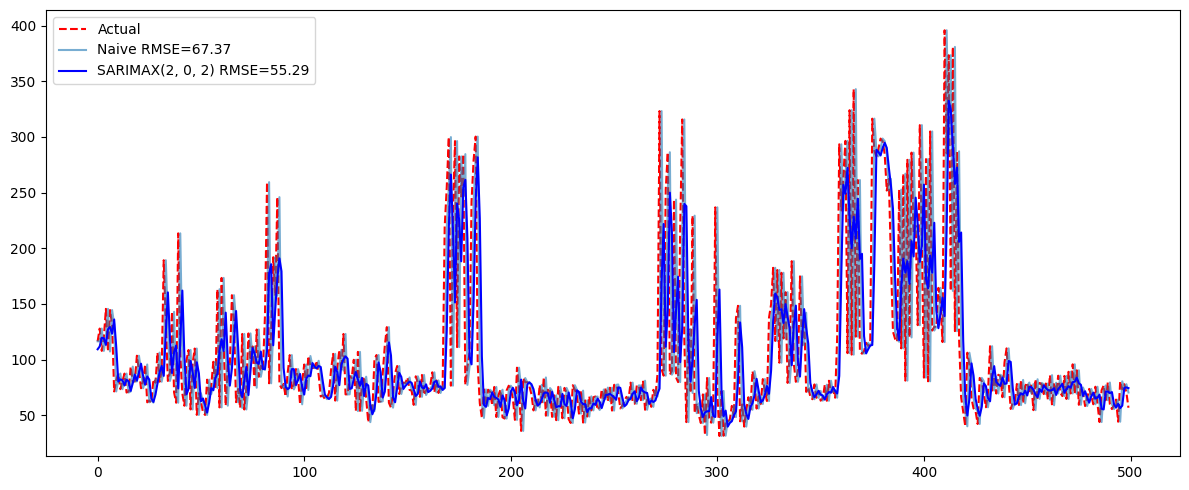

                               SARIMAX Results                                
Dep. Variable:               OV_model   No. Observations:                 1773
Model:               SARIMAX(2, 0, 2)   Log Likelihood               -9137.503
Date:                Tue, 20 Jan 2026   AIC                          18293.007
Time:                        23:08:51   BIC                          18342.315
Sample:                             0   HQIC                         18311.224
                               - 1773                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
OV_lag1           0.2608      1.353      0.193      0.847      -2.390       2.912
OV_lag2           0.4686      0.535      0.876      0.381      -0.579       1.517
OV_roll_mean3     0.2630      0.974     

In [11]:
# --- SARIMAX: orderを軽く探索して一番良いものを採用 ---
# 評価は元スケール（OV_orig）で揃える

import warnings
from statsmodels.tools.sm_exceptions import ValueWarning

def inv_y(x):
    return np.expm1(x) if USE_LOG_Y else x

orders = [
    (1, 0, 0),
    (1, 0, 1),
    (1, 1, 0),
    (1, 1, 1),
    (2, 0, 0),
    (2, 0, 1),
    (2, 0, 2),
    (2, 1, 0),
    (2, 1, 1),
    (2, 1, 2),
    (0, 1, 0),
    (0, 1, 1),
    (0, 1, 2),
    (0, 0, 1),
    (0, 0, 2),
    (1, 0, 2),
    (1, 1, 2),
    (2, 0, 2),
    (2, 1, 2),
    (3, 0, 0),
    (3, 0, 1),
    (3, 0, 2),
    (3, 1, 0),
    (3, 1, 1),
    (3, 1, 2),
]

best_order = None
best_rmse = float("inf")
best_res = None
best_pred_orig = None

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ValueWarning)
    warnings.filterwarnings("ignore", category=FutureWarning)

    for order in orders:
        try:
            model = sm.tsa.SARIMAX(
                y_train,
                exog=exog_train,
                order=order,
                enforce_stationarity=False,
                enforce_invertibility=False,
            )
            res = model.fit(disp=False)
            pred_model = res.get_forecast(steps=len(y_test), exog=exog_test).predicted_mean
            pred_orig = inv_y(pred_model)
            rmse = float(np.sqrt(mean_squared_error(y_test_orig, pred_orig)))
            print("order", order, "RMSE", rmse)

            if rmse < best_rmse:
                best_rmse = rmse
                best_order = order
                best_res = res
                best_pred_orig = pred_orig
        except Exception as e:
            print("order", order, "failed:", type(e).__name__, str(e)[:120])

print("\nBest SARIMAX:", best_order, "RMSE:", best_rmse)
print("Baseline (naive, mean):", rmse_naive, rmse_mean)

# --- 可視化 ---
plt.figure(figsize=(12, 5))
plt.plot(y_test_orig.reset_index(drop=True), label="Actual", color="red", linestyle="--")
plt.plot(y_test_orig.shift(1).bfill().reset_index(drop=True), label=f"Naive RMSE={rmse_naive:.2f}", alpha=0.6)
if best_pred_orig is not None:
    plt.plot(pd.Series(best_pred_orig).reset_index(drop=True), label=f"SARIMAX{best_order} RMSE={best_rmse:.2f}", color="blue")
plt.legend()
plt.tight_layout()
plt.show()

# サマリ（必要なときだけ）
if best_res is not None:
    print(best_res.summary())


## 次の一手（精度改善）

- `order=(p,d,q)` を複数試してRMSEが良いものを選ぶ
- `USE_EXOG=True` にして外生変数（`X1..X83`）を投入する（ただし過学習に注意）
- ラグ特徴（例：`OV_lag1` など）をexogとして追加して「状態空間 + 追加特徴」で精度を上げる
